In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

from GPyOpt.methods import BayesianOptimization
import GPy
import GPyOpt
from numpy.random import seed
from tqdm import *

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from GPyOpt.objective_examples.experiments2d import function2d
import numpy as np
class SynthObj2d(function2d):
    '''
    Cosines function
    
    :param bounds: the box constraints to define the domain in which the function is optimized.
    :param sd: standard deviation, to generate noisy evaluations of the function.
    '''
    def __init__(self,bounds=None,sd=None):
        self.input_dim = 2
        if bounds == None: self.bounds = [(0,10),(0,10)]
        else: self.bounds = bounds
        self.min = [(0, 0)]
        self.fmin = 0
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.name = 'MyObj'

    def f(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim:
            return 'Wrong input dimension'
        else:
            fval = (np.sin(X[:,0]/3)>X[:,1]/10)*2
            if self.sd ==0:
                noise = np.zeros(n).reshape(n,1)
            else:
                noise = np.random.normal(0,self.sd,n).reshape(n,1)
            return -fval.reshape(n,1) + noise
        
    def boundary_plot(self, fig):
        x = np.linspace(0,10,100)
        y = 10 * np.sin(x/3)
        fig.add_subplot(2,2,1)
        plt.plot(x,y)
        plt.title('(a) Ground Truth Phase Boundary', loc='left')
        plt.xlim(0,10)
        plt.ylim(0,10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.colorbar()

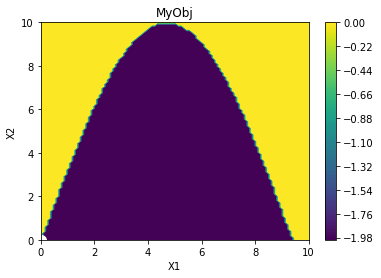

In [11]:
obj = SynthObj2d()
myf = obj.f
obj.plot()

In [62]:
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.acquisitions.EI import AcquisitionEI
from numpy.random import beta

objective = GPyOpt.core.task.SingleObjective(obj.f)


model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

space = GPyOpt.Design_space(space =[{'name': 'x1', 'type': 'continuous', 'domain': (0,10)},
                                    {'name': 'x2', 'type': 'continuous', 'domain': (0,15)}])

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 10)

In [80]:
# Copyright (c) 2018, the Chengyu Dai @ Glotzer Group

from GPyOpt.acquisitions import AcquisitionBase
import numpy as np

class AcquisitionBinaryT(AcquisitionBase):
    """
    T value acquisition function for active classification with binary classes

    :param model: GPyOpt class of model
    :param space: GPyOpt class of domain
    :param optimizer: optimizer of the acquisition. Should be a GPyOpt optimizer
    :param cost_withGradients: function
    :param epsilon: positive value to make the acquisition more explorative.

    .. Note:: allows to compute the Improvement per unit of cost
    """

    analytical_gradient_prediction = True

    def __init__(self, model, space, optimizer=None, cost_withGradients=None, epsilon=0.01):
        self.optimizer = optimizer
        super(AcquisitionBinaryT, self).__init__(model, space, optimizer,
                                                 cost_withGradients=cost_withGradients)
        self.epsilon = epsilon

    @staticmethod
    def fromConfig(model, space, optimizer, cost_withGradients, config):
        return AcquisitionBinaryT(model, space, optimizer, cost_withGradients,
                                  epsilon=config['epsilon'])

    def acquisition_function(self, x):
        """
        Computes the Expected Improvement per unit of cost
        """
        m, s = self.model.predict(x)
        f_acqu = s / (np.abs(m) + self.epsilon)
        return -f_acqu

    def acquisition_function_withGradients(self, x):
        """
        Computes the Expected Improvement and its derivative (has a very easy derivative!)
        """
        fmin = self.model.get_fmin()
        m, s, dmdx, dsdx = self.model.predict_withGradients(x)
        f_acqu = s / (np.abs(m) + self.epsilon)
        df_acqu = (dsdx) / (np.abs(m) + self.epsilon) \
                - (s) * np.sign(m) * dmdx / (np.abs(m) + self.epsilon) / (np.abs(m) + self.epsilon)
        return -f_acqu, -df_acqu

acquisition = AcquisitionBinaryT(model, space, optimizer=aquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [81]:
bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator, initial_design
)

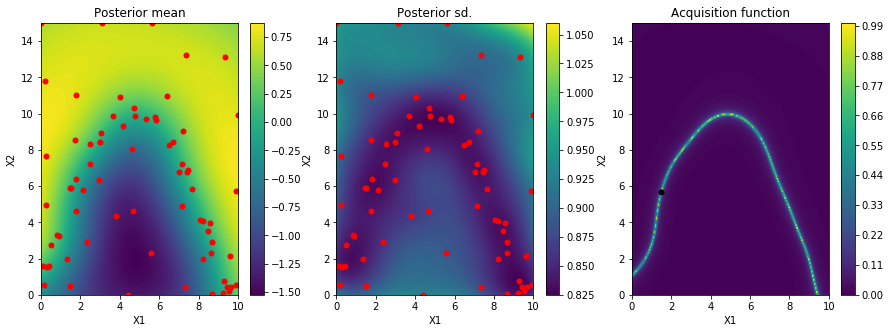

In [86]:
max_iter = 50
bo.run_optimization(max_iter=max_iter)
bo.plot_acquisition()

In [87]:
len(bo.X)

71